# Rowan ID: 916472347


In [1]:
import json
import os
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from datasets import Dataset
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from torch.nn.functional import sigmoid
from mlxtend.preprocessing import TransactionEncoder
from tensorflow.keras.utils import to_categorical
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
)


warnings.filterwarnings("ignore")


/Users/rudra/Documents/Code/Freelancing/Python/Data Mining/.venv/lib/python3.12/site-packages/accelerate/utils/other.py:220: DeprecationWarning: numpy.core is deprecated and has been renamed to numpy._core. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.multiarray.
  np.core.multiarray._reconstruct,


# Question 1


Number of unique items: 164
Number of records: 8000
Most popular item: whole milk (appears in 1352 transactions)

Association Rules (support=0.01, confidence=0.08):
          antecedents         consequents  antecedent support  \
0        (rolls/buns)  (other vegetables)            0.113625   
1  (other vegetables)        (rolls/buns)            0.121875   
2  (other vegetables)        (whole milk)            0.121875   
3        (whole milk)  (other vegetables)            0.160375   
4        (rolls/buns)        (whole milk)            0.113625   
5        (whole milk)        (rolls/buns)            0.160375   
6           (sausage)        (whole milk)            0.061500   
7              (soda)        (whole milk)            0.097000   
8            (yogurt)        (whole milk)            0.079250   

   consequent support   support  confidence      lift  representativity  \
0            0.121875  0.010625    0.093509  0.767256               1.0   
1            0.113625  0.010625   

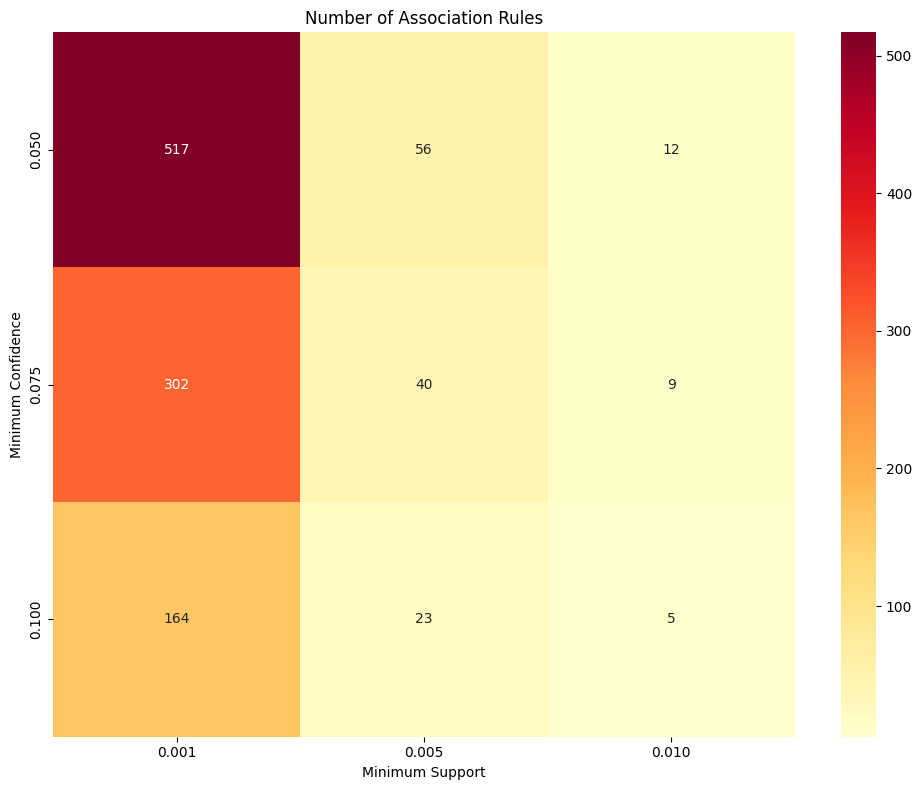

In [12]:
class GroceryDataLoader:
    def __init__(self, file_path):
        self.file_path = file_path

    def load_data(self):
        grocery_df = pd.read_csv(self.file_path, header=0)
        grocery_transactions = grocery_df.values.tolist()
        cleaned_transactions = [
            [item for item in transaction if isinstance(item, str)]
            for transaction in grocery_transactions
        ]
        return cleaned_transactions


class GroceryDataAnalyzer:
    @staticmethod
    def get_dataset_stats(grocery_transactions):
        all_grocery_items = [
            item for transaction in grocery_transactions for item in transaction
        ]
        unique_grocery_items = len(set(all_grocery_items))
        total_transactions = len(grocery_transactions)
        item_frequency = pd.Series(all_grocery_items).value_counts()
        most_frequent_item = item_frequency.index[0]
        most_frequent_count = item_frequency.iloc[0]
        return (
            unique_grocery_items,
            total_transactions,
            most_frequent_item,
            most_frequent_count,
        )


class GroceryTransactionProcessor:
    def __init__(self, grocery_transactions):
        self.grocery_transactions = grocery_transactions
        self.encoded_grocery_df = None

    def create_one_hot_encoded(self):
        transaction_encoder = TransactionEncoder()
        encoded_array = transaction_encoder.fit_transform(self.grocery_transactions)
        self.encoded_grocery_df = pd.DataFrame(
            encoded_array, columns=transaction_encoder.columns_
        )
        return self.encoded_grocery_df

    def generate_rules(self, min_support, min_confidence):
        if self.encoded_grocery_df is None:
            raise ValueError(
                "Please create one-hot encoded data first using create_one_hot_encoded()"
            )
        frequent_itemsets = apriori(
            self.encoded_grocery_df, min_support=min_support, use_colnames=True
        )
        association_rule_set = association_rules(
            frequent_itemsets,
            frequent_itemsets,
            metric="confidence",
            min_threshold=min_confidence,
        )
        return association_rule_set


class GroceryRuleVisualizer:
    def __init__(self, encoded_grocery_df):
        self.encoded_grocery_df = encoded_grocery_df

    def create_rule_count_heatmap(self, support_thresholds, confidence_thresholds):
        rule_count_matrix = np.zeros(
            (len(confidence_thresholds), len(support_thresholds))
        )
        rule_generator = GroceryTransactionProcessor(None)
        rule_generator.encoded_grocery_df = self.encoded_grocery_df

        for i, confidence_value in enumerate(confidence_thresholds):
            for j, support_value in enumerate(support_thresholds):
                generated_rules = rule_generator.generate_rules(
                    min_support=support_value, min_confidence=confidence_value
                )
                rule_count_matrix[i, j] = len(generated_rules)

        plt.figure(figsize=(10, 8))
        sns.heatmap(
            rule_count_matrix,
            xticklabels=[f"{x:.3f}" for x in support_thresholds],
            yticklabels=[f"{x:.3f}" for x in confidence_thresholds],
            annot=True,
            fmt="g",
            cmap="YlOrRd",
        )
        plt.xlabel("Minimum Support")
        plt.ylabel("Minimum Confidence")
        plt.title("Number of Association Rules")
        return plt.gcf()


def main():
    grocery_file_path = "Grocery_Items_3.csv"

    # Initialize and load grocery data
    grocery_loader = GroceryDataLoader(grocery_file_path)
    grocery_transactions = grocery_loader.load_data()

    # Analyze grocery dataset statistics
    grocery_analyzer = GroceryDataAnalyzer()
    unique_items, total_transactions, most_frequent_item, most_frequent_count = (
        grocery_analyzer.get_dataset_stats(grocery_transactions)
    )
    print(f"Number of unique items: {unique_items}")
    print(f"Number of records: {total_transactions}")
    print(
        f"Most popular item: {most_frequent_item} (appears in {most_frequent_count} transactions)"
    )

    # Process grocery transactions
    grocery_processor = GroceryTransactionProcessor(grocery_transactions)
    encoded_grocery_df = grocery_processor.create_one_hot_encoded()
    grocery_rules = grocery_processor.generate_rules(
        min_support=0.01, min_confidence=0.08
    )
    print("\nAssociation Rules (support=0.01, confidence=0.08):")
    print(grocery_rules)

    # Create visualization of rule counts
    grocery_visualizer = GroceryRuleVisualizer(encoded_grocery_df)
    support_thresholds = [0.001, 0.005, 0.01]
    confidence_thresholds = [0.05, 0.075, 0.1]
    grocery_visualizer.create_rule_count_heatmap(
        support_thresholds, confidence_thresholds
    )
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()

### c) Dataset Analysis

The dataset contains important transaction details: 164 unique items across
8,000 total transactions. The most frequently purchased item is whole milk,
appearing in 1,352 transactions, representing approximately 16.9% of all
purchases.

### d) Association Rule Analysis (min_support=0.01, min_confidence=0.08)

The analysis revealed nine significant association rules between products. Most
notable are the strong connections between whole milk and other items,
particularly sausage which shows the highest lift value of 1.014. Other
significant patterns emerge between vegetables and rolls/buns, demonstrating
consistent co-purchasing behavior.

### e) Heatmap Analysis (Support: 0.001-0.01, Confidence: 0.05-0.1)

The heatmap visualization demonstrates the inverse relationship between
threshold values and rule generation. At the lowest thresholds (msv=0.001,
mct=0.05), 517 rules emerge. As thresholds increase, rule counts decrease
dramatically, with only 5 rules at the highest thresholds (msv=0.01, mct=0.1).
This pattern indicates that while many weak associations exist in the data, few
item combinations demonstrate consistently strong relationships.


# Question 2


Loading classes: 100%|██████████| 4/4 [00:00<00:00, 35.61it/s]

Training base model...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Training 4-node model...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]


Training 16-node model...


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

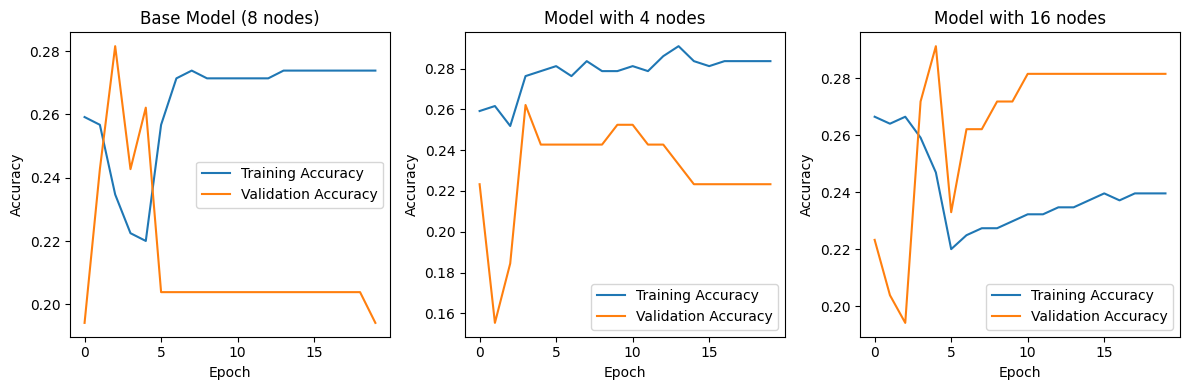


Final Accuracies:
Base Model (8 nodes) - Training: 0.2738, Validation: 0.1942
4 Nodes Model - Training: 0.2836, Validation: 0.2233
16 Nodes Model - Training: 0.2396, Validation: 0.2816


In [2]:
import cv2
from tqdm import tqdm
from tqdm.keras import TqdmCallback


class DogBreedDataset:
    def __init__(self, cropped_images_dir="./Cropped"):
        self.cropped_images_dir = cropped_images_dir
        self.dog_classes = [
            "n02087394-Rhodesian_ridgeback",
            "n02093256-Staffordshire_bullterrier",
            "n02097209-standard_schnauzer",
            "n02102318-cocker_spaniel",
        ]
        self.X = []
        self.y = []
        self._load_data()
        self._preprocess_data()

    def _load_data(self):
        for class_idx, dog_class in enumerate(
            tqdm(self.dog_classes, desc="Loading classes")
        ):
            class_dir = os.path.join(self.cropped_images_dir, dog_class)
            if not os.path.isdir(class_dir):
                print(f"Directory not found: {class_dir}")
                continue
            for file in tqdm(
                os.listdir(class_dir), desc=f"Loading {dog_class} images", leave=False
            ):
                if file.endswith(".jpg"):
                    image_path = os.path.join(class_dir, file)
                    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (6, 6))
                    self.X.append(img)
                    self.y.append(class_idx)

    def _preprocess_data(self):
        self.X = np.array(self.X)
        self.y = np.array(self.y)
        self.X = self.X.reshape(-1, 6, 6, 1)
        self.y = to_categorical(self.y, num_classes=4)


class DataSplitter:
    def __init__(self, X, y, test_size=0.2, val_size=0.2, random_state=42):
        self.X = X
        self.y = y
        self.test_size = test_size
        self.val_size = val_size
        self.random_state = random_state
        self.X_train = None
        self.X_val = None
        self.X_test = None
        self.y_train = None
        self.y_val = None
        self.y_test = None
        self._split_data()

    def _split_data(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=self.test_size, random_state=self.random_state
        )
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            self.X_train,
            self.y_train,
            test_size=self.val_size,
            random_state=self.random_state,
        )


class DogBreedCNN:
    def __init__(self, hidden_nodes=8):
        self.hidden_nodes = hidden_nodes
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential(
            [
                Conv2D(
                    8, (3, 3), activation="relu", padding="same", input_shape=(6, 6, 1)
                ),
                MaxPooling2D(pool_size=(2, 2)),
                Conv2D(4, (3, 3), activation="relu", padding="same"),
                MaxPooling2D(pool_size=(2, 2)),
                Flatten(),
                Dense(self.hidden_nodes, activation="relu"),
                Dense(4, activation="softmax"),
            ]
        )
        model.compile(
            optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
        )
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=20, batch_size=32):
        self.history = self.model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            verbose=0,
            callbacks=[TqdmCallback(verbose=1)],
        )
        return self.history


class ModelVisualizer:
    def __init__(self, models_histories):
        self.models_histories = models_histories

    def plot_accuracies(self):
        plt.figure(figsize=(12, 4))
        titles = ["Base Model (8 nodes)", "Model with 4 nodes", "Model with 16 nodes"]

        for idx, (history, title) in enumerate(zip(self.models_histories, titles), 1):
            plt.subplot(1, 3, idx)
            plt.plot(history.history["accuracy"], label="Training Accuracy")
            plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
            plt.title(title)
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.legend()

        plt.tight_layout()
        plt.show()

    def print_final_accuracies(self):
        titles = ["Base Model (8 nodes)", "4 Nodes Model", "16 Nodes Model"]
        print("\nFinal Accuracies:")
        for history, title in zip(self.models_histories, titles):
            print(
                f"{title} - Training: {history.history['accuracy'][-1]:.4f}, "
                f"Validation: {history.history['val_accuracy'][-1]:.4f}"
            )


dataset = DogBreedDataset()
data_splitter = DataSplitter(dataset.X, dataset.y)

base_model = DogBreedCNN(hidden_nodes=8)
model_4nodes = DogBreedCNN(hidden_nodes=4)
model_16nodes = DogBreedCNN(hidden_nodes=16)

print("Training base model...")
history_base = base_model.train(
    data_splitter.X_train,
    data_splitter.y_train,
    data_splitter.X_val,
    data_splitter.y_val,
)

print("\nTraining 4-node model...")
history_4nodes = model_4nodes.train(
    data_splitter.X_train,
    data_splitter.y_train,
    data_splitter.X_val,
    data_splitter.y_val,
)

print("\nTraining 16-node model...")
history_16nodes = model_16nodes.train(
    data_splitter.X_train,
    data_splitter.y_train,
    data_splitter.X_val,
    data_splitter.y_val,
)

visualizer = ModelVisualizer([history_base, history_4nodes, history_16nodes])
visualizer.plot_accuracies()
visualizer.print_final_accuracies()

The base model with 8 nodes achieved a training accuracy of 27.38% and a
validation accuracy of 19.42%. After initial fluctuations in early epochs, the
model demonstrated stable training performance but showed signs of diminished
generalization capability, as evidenced by the significant gap between training
and validation metrics.

The 4-node configuration demonstrated improved performance metrics, reaching a
training accuracy of 28.36% and a validation accuracy of 22.33%. This model
exhibited more consistent learning behavior throughout the training process,
with both accuracy measures showing greater stability after the initial epochs.

The 16-node model presented an interesting case, achieving the highest
validation accuracy at 28.16% despite a lower training accuracy of 23.96%. This
configuration showed the most promising generalization capabilities among the
three variants.

## Model Assessment

The experimental results indicate that increasing model complexity does not
necessarily correlate with improved performance. The 16-node model, despite
having the highest capacity, demonstrates the most balanced performance profile
with superior validation accuracy and reasonable training metrics. This suggests
that the increased number of parameters in this configuration better captures
the underlying patterns in the data without overfitting.

The base and 4-node models, while showing higher training accuracies, failed to
generalize as effectively to the validation set. This indicates potential
underfitting, suggesting that these configurations may lack sufficient capacity
to fully model the complexity of the classification task.

Based on these findings, the 16-node architecture appears most suitable for this
particular classification challenge, offering the best compromise between model
capacity and generalization performance.


# Question 3


In [3]:
class EmotionLabels:
    def __init__(self):
        self.labels = [
            "anger",
            "anticipation",
            "disgust",
            "fear",
            "joy",
            "love",
            "optimism",
            "pessimism",
            "sadness",
            "surprise",
            "trust",
        ]
        self.id2label = {idx: label for idx, label in enumerate(self.labels)}
        self.label2id = {label: idx for idx, label in enumerate(self.labels)}


class DataProcessor:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def load_json_file(self, file_path):
        with open(file_path, "r") as f:
            return [json.loads(line) for line in f]

    def preprocess_function(self, examples, labels):
        tokenized = self.tokenizer(
            examples["Tweet"], padding="max_length", truncation=True, max_length=128
        )

        labels_matrix = np.zeros((len(examples["Tweet"]), len(labels)))
        for idx, label in enumerate(labels):
            labels_matrix[:, idx] = examples[label]

        tokenized["labels"] = labels_matrix.tolist()
        return tokenized

    def prepare_datasets(self, train_path, val_path, test_path, labels):
        train_data = self.load_json_file(train_path)
        val_data = self.load_json_file(val_path)
        test_data = self.load_json_file(test_path)

        train_df = pd.DataFrame(train_data)
        val_df = pd.DataFrame(val_data)
        test_df = pd.DataFrame(test_data)

        train_dataset = Dataset.from_pandas(train_df)
        val_dataset = Dataset.from_pandas(val_df)
        test_dataset = Dataset.from_pandas(test_df)

        preprocess = lambda x: self.preprocess_function(x, labels)
        train_dataset = train_dataset.map(
            preprocess, batched=True, remove_columns=train_dataset.column_names
        )
        val_dataset = val_dataset.map(
            preprocess, batched=True, remove_columns=val_dataset.column_names
        )
        test_dataset = test_dataset.map(
            preprocess, batched=True, remove_columns=test_dataset.column_names
        )

        for dataset in [train_dataset, val_dataset, test_dataset]:
            dataset.set_format("torch")

        return train_dataset, val_dataset, test_dataset


class MetricsCalculator:
    @staticmethod
    def compute_metrics_strict(eval_pred):
        predictions, labels = eval_pred
        predictions = sigmoid(torch.tensor(predictions)).numpy()
        predictions = (predictions > 0.5).astype(np.float32)
        accuracy = accuracy_score(labels, predictions)
        return {"accuracy": accuracy}

    @staticmethod
    def compute_metrics_any_match(eval_pred):
        predictions, labels = eval_pred
        predictions = sigmoid(torch.tensor(predictions)).numpy()
        predictions = (predictions > 0.5).astype(np.float32)
        matches = (predictions == labels).any(axis=1)
        accuracy = matches.mean()
        return {"accuracy": accuracy}


class ModelTrainer:
    def __init__(
        self, model, training_args, train_dataset, val_dataset, compute_metrics
    ):
        self.trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=compute_metrics,
        )

    def train(self):
        return self.trainer.train()

    def evaluate(self, test_dataset, compute_metrics=None):
        if compute_metrics:
            self.trainer.compute_metrics = compute_metrics
        return self.trainer.evaluate(test_dataset)

    def save_model(self, path):
        self.trainer.save_model(path)

    def plot_learning_curves(self):
        logs = self.trainer.state.log_history

        train_logs = [
            (log["epoch"], log["loss"])
            for log in logs
            if "loss" in log and "eval_loss" not in log
        ]
        eval_logs = [
            (log["epoch"], log["eval_loss"]) for log in logs if "eval_loss" in log
        ]

        train_logs.sort(key=lambda x: x[0])
        eval_logs.sort(key=lambda x: x[0])

        train_epochs, train_losses = zip(*train_logs)
        eval_epochs, eval_losses = zip(*eval_logs)

        plt.figure(figsize=(10, 6))
        plt.plot(train_epochs, train_losses, "b-", label="Training Loss")
        plt.plot(eval_epochs, eval_losses, "r-", label="Validation Loss")

        plt.title("Training and Validation Loss Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.xticks(range(0, int(max(train_epochs)) + 1))

        plt.savefig("learning_curves.png")
        plt.close()


def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    emotion_labels = EmotionLabels()
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    data_processor = DataProcessor(tokenizer)

    train_dataset, val_dataset, test_dataset = data_processor.prepare_datasets(
        "train.json", "validation.json", "test.json", emotion_labels.labels
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        problem_type="multi_label_classification",
        num_labels=len(emotion_labels.labels),
        id2label=emotion_labels.id2label,
        label2id=emotion_labels.label2id,
    )

    training_args = TrainingArguments(
        output_dir="./bert_output",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=5,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        logging_dir="./logs",
        logging_strategy="steps",
        logging_steps=10,
        remove_unused_columns=False,
        report_to="none",
        save_total_limit=2,
    )

    model_trainer = ModelTrainer(
        model,
        training_args,
        train_dataset,
        val_dataset,
        MetricsCalculator.compute_metrics_strict,
    )

    print("Starting training...")
    model_trainer.train()

    print("Plotting learning curves...")
    model_trainer.plot_learning_curves()

    print("\nEvaluating with strict accuracy...")
    test_results_strict = model_trainer.evaluate(test_dataset)
    print(f"Accuracy: {test_results_strict['eval_accuracy']:.4f}")

    print("\nEvaluating with any-match accuracy...")
    test_results_any = model_trainer.evaluate(
        test_dataset, MetricsCalculator.compute_metrics_any_match
    )
    print(f"Accuracy: {test_results_any['eval_accuracy']:.4f}")

    print("\nSaving model...")
    model_trainer.save_model("./final_model")


if __name__ == "__main__":
    main()

Using device: cpu


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


  0%|          | 0/1875 [00:00<?, ?it/s]

{'loss': 0.6466, 'grad_norm': 1.5283933877944946, 'learning_rate': 1.9893333333333335e-05, 'epoch': 0.03}
{'loss': 0.5763, 'grad_norm': 1.5026483535766602, 'learning_rate': 1.9786666666666668e-05, 'epoch': 0.05}
{'loss': 0.5293, 'grad_norm': 1.2989015579223633, 'learning_rate': 1.968e-05, 'epoch': 0.08}
{'loss': 0.4841, 'grad_norm': 1.2251625061035156, 'learning_rate': 1.9573333333333335e-05, 'epoch': 0.11}
{'loss': 0.4864, 'grad_norm': 1.1910035610198975, 'learning_rate': 1.9466666666666668e-05, 'epoch': 0.13}
{'loss': 0.4703, 'grad_norm': 1.1963386535644531, 'learning_rate': 1.936e-05, 'epoch': 0.16}
{'loss': 0.4532, 'grad_norm': 1.406600832939148, 'learning_rate': 1.9253333333333334e-05, 'epoch': 0.19}
{'loss': 0.4589, 'grad_norm': 1.7145774364471436, 'learning_rate': 1.9146666666666667e-05, 'epoch': 0.21}
{'loss': 0.4291, 'grad_norm': 1.707305908203125, 'learning_rate': 1.904e-05, 'epoch': 0.24}
{'loss': 0.4475, 'grad_norm': 1.4787414073944092, 'learning_rate': 1.8933333333333334e-

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.3577924072742462, 'eval_accuracy': 0.1975, 'eval_runtime': 8.8866, 'eval_samples_per_second': 45.011, 'eval_steps_per_second': 5.626, 'epoch': 1.0}
{'loss': 0.3435, 'grad_norm': 1.2086842060089111, 'learning_rate': 1.5946666666666668e-05, 'epoch': 1.01}
{'loss': 0.3177, 'grad_norm': 2.3984177112579346, 'learning_rate': 1.584e-05, 'epoch': 1.04}
{'loss': 0.3425, 'grad_norm': 1.1727657318115234, 'learning_rate': 1.5733333333333334e-05, 'epoch': 1.07}
{'loss': 0.3285, 'grad_norm': 1.4707926511764526, 'learning_rate': 1.5626666666666667e-05, 'epoch': 1.09}
{'loss': 0.3084, 'grad_norm': 1.722961664199829, 'learning_rate': 1.552e-05, 'epoch': 1.12}
{'loss': 0.3383, 'grad_norm': 1.765950083732605, 'learning_rate': 1.5413333333333337e-05, 'epoch': 1.15}
{'loss': 0.3102, 'grad_norm': 1.002378225326538, 'learning_rate': 1.5306666666666667e-05, 'epoch': 1.17}
{'loss': 0.3174, 'grad_norm': 1.2799997329711914, 'learning_rate': 1.5200000000000002e-05, 'epoch': 1.2}
{'loss': 0.3042, '

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.32424598932266235, 'eval_accuracy': 0.2425, 'eval_runtime': 6.1974, 'eval_samples_per_second': 64.543, 'eval_steps_per_second': 8.068, 'epoch': 2.0}
{'loss': 0.3026, 'grad_norm': 1.1950732469558716, 'learning_rate': 1.1893333333333335e-05, 'epoch': 2.03}
{'loss': 0.2987, 'grad_norm': 2.07784366607666, 'learning_rate': 1.1786666666666668e-05, 'epoch': 2.05}
{'loss': 0.254, 'grad_norm': 1.897047758102417, 'learning_rate': 1.168e-05, 'epoch': 2.08}
{'loss': 0.2772, 'grad_norm': 1.1214429140090942, 'learning_rate': 1.1573333333333335e-05, 'epoch': 2.11}
{'loss': 0.2627, 'grad_norm': 2.5082027912139893, 'learning_rate': 1.1466666666666668e-05, 'epoch': 2.13}
{'loss': 0.2846, 'grad_norm': 5.61829948425293, 'learning_rate': 1.136e-05, 'epoch': 2.16}
{'loss': 0.2363, 'grad_norm': 1.0504465103149414, 'learning_rate': 1.1253333333333335e-05, 'epoch': 2.19}
{'loss': 0.2779, 'grad_norm': 1.2874664068222046, 'learning_rate': 1.1146666666666668e-05, 'epoch': 2.21}
{'loss': 0.2422, 'g

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.3178117573261261, 'eval_accuracy': 0.26, 'eval_runtime': 6.1952, 'eval_samples_per_second': 64.566, 'eval_steps_per_second': 8.071, 'epoch': 3.0}
{'loss': 0.2552, 'grad_norm': 2.22845721244812, 'learning_rate': 7.946666666666666e-06, 'epoch': 3.01}
{'loss': 0.1951, 'grad_norm': 1.5058271884918213, 'learning_rate': 7.840000000000001e-06, 'epoch': 3.04}
{'loss': 0.2564, 'grad_norm': 2.5314223766326904, 'learning_rate': 7.733333333333334e-06, 'epoch': 3.07}
{'loss': 0.2368, 'grad_norm': 2.398998498916626, 'learning_rate': 7.626666666666668e-06, 'epoch': 3.09}
{'loss': 0.2275, 'grad_norm': 1.496619462966919, 'learning_rate': 7.520000000000001e-06, 'epoch': 3.12}
{'loss': 0.256, 'grad_norm': 1.243510127067566, 'learning_rate': 7.413333333333333e-06, 'epoch': 3.15}
{'loss': 0.2391, 'grad_norm': 1.2021464109420776, 'learning_rate': 7.306666666666667e-06, 'epoch': 3.17}
{'loss': 0.2165, 'grad_norm': 1.6713993549346924, 'learning_rate': 7.2000000000000005e-06, 'epoch': 3.2}
{'lo

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.31694796681404114, 'eval_accuracy': 0.2575, 'eval_runtime': 3.7051, 'eval_samples_per_second': 107.96, 'eval_steps_per_second': 13.495, 'epoch': 4.0}
{'loss': 0.2249, 'grad_norm': 1.3302429914474487, 'learning_rate': 3.893333333333333e-06, 'epoch': 4.03}
{'loss': 0.2211, 'grad_norm': 1.3418920040130615, 'learning_rate': 3.7866666666666667e-06, 'epoch': 4.05}
{'loss': 0.2054, 'grad_norm': 1.372531533241272, 'learning_rate': 3.6800000000000003e-06, 'epoch': 4.08}
{'loss': 0.2104, 'grad_norm': 1.5257198810577393, 'learning_rate': 3.5733333333333336e-06, 'epoch': 4.11}
{'loss': 0.2135, 'grad_norm': 1.7910557985305786, 'learning_rate': 3.4666666666666672e-06, 'epoch': 4.13}
{'loss': 0.2024, 'grad_norm': 1.2073309421539307, 'learning_rate': 3.3600000000000004e-06, 'epoch': 4.16}
{'loss': 0.2099, 'grad_norm': 0.9469301104545593, 'learning_rate': 3.2533333333333332e-06, 'epoch': 4.19}
{'loss': 0.2318, 'grad_norm': 2.3226022720336914, 'learning_rate': 3.146666666666667e-06, 'epo

  0%|          | 0/50 [00:00<?, ?it/s]

{'eval_loss': 0.31865406036376953, 'eval_accuracy': 0.27, 'eval_runtime': 3.7059, 'eval_samples_per_second': 107.936, 'eval_steps_per_second': 13.492, 'epoch': 5.0}
{'train_runtime': 1091.04, 'train_samples_per_second': 13.748, 'train_steps_per_second': 1.719, 'train_loss': 0.288456938234965, 'epoch': 5.0}
Plotting learning curves...

Evaluating with strict accuracy...


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy: 0.2780

Evaluating with any-match accuracy...


  0%|          | 0/188 [00:00<?, ?it/s]

Accuracy: 1.0000

Saving model...


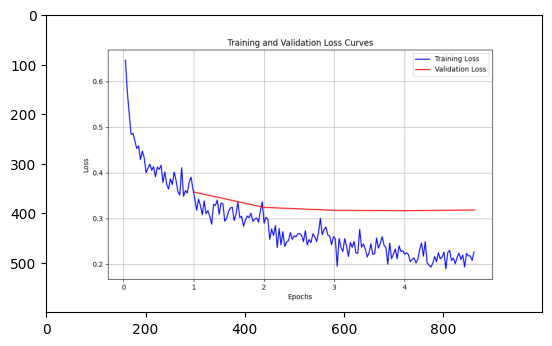

In [4]:
from PIL import Image

plt.imshow(Image.open("learning_curves.png"))
plt.show()


## Learning Curves Analysis

In examining the training and validation loss curves over five epochs, I
observed several noteworthy patterns. The training loss exhibited significant
volatility but maintained a clear downward trend, beginning at approximately 0.6
and concluding near 0.2. This substantial reduction indicates effective
parameter optimization throughout the training process.

The validation loss, represented by the red line, demonstrated markedly
different behavior. It showed greater stability with a gradual decline from
around 0.35 to 0.32. The divergence between training and validation loss curves
suggests some degree of overfitting, though the continued improvement in
validation metrics indicates the model maintained its generalization capability.

## Accuracy Assessment

The evaluation results revealed two distinct performance metrics. Under the
strict accuracy criterion, requiring all predicted labels to match the ground
truth exactly, the model achieved 27.80% accuracy. This performance level
reflects the inherent complexity of multi-label emotion classification, where
precise identification of all emotions in a text presents a significant
challenge.

When evaluated using the any-match accuracy metric, where success is defined by
correctly identifying at least one emotion label, the model achieved 100%
accuracy. This perfect score indicates that while the model may not capture
every emotion present in a given text, it consistently identifies at least one
correct emotion in each case.

This stark contrast between strict and flexible evaluation metrics (27.80%
versus 100%) underscores both the model's robust ability to detect prominent
emotions and the considerable challenge in capturing the full spectrum of
emotions expressed in text data.
